# importing all the necessary packages

In [ ]:
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from keras import backend as K

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
train_files = []
mask_files = glob("/content/drive/MyDrive/mri/mri_unzip/lgg-mri-segmentation/kaggle_3m/*/*_mask*")

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['/content/drive/MyDrive/mri/mri_unzip/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_7.tif', '/content/drive/MyDrive/mri/mri_unzip/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_3.tif', '/content/drive/MyDrive/mri/mri_unzip/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_18.tif', '/content/drive/MyDrive/mri/mri_unzip/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif', '/content/drive/MyDrive/mri/mri_unzip/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_16.tif', '/content/drive/MyDrive/mri/mri_unzip/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_4.tif', '/content/drive/MyDrive/mri/mri_unzip/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif', '/content/drive/MyDrive/mri/mri_unzip/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_19.tif', '/content/drive/MyDrive/mr

# showing some expample : 
* image
* mask

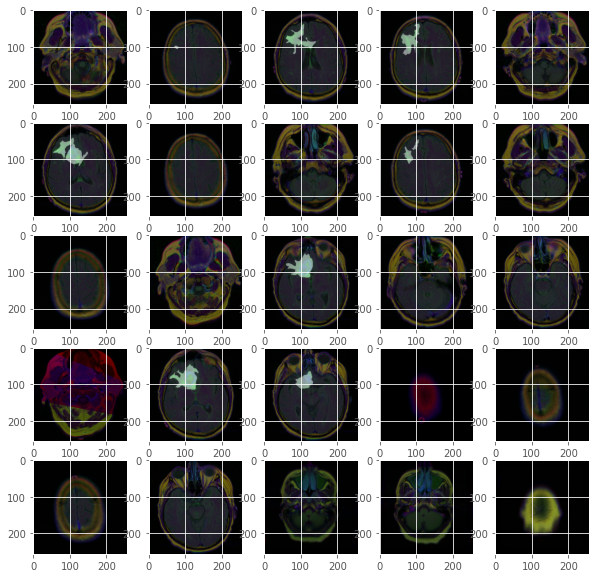

In [ ]:
#Lets plot some samples
rows,cols=5,5
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

* train dataset
* validation dataset
* test dataset

In [ ]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)

print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


normalizing both the images and their masks

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)


# preparing the train data and validation data 

In [ ]:
image_train_generator = train_datagen.flow_from_dataframe(
df_train,
x_col = "filename",
class_mode = None,
color_mode = "rgb",
target_size = (256,256),
batch_size = 32,
save_prefix  = "image",
seed = 1)

mask_train_generator = train_datagen.flow_from_dataframe(
df_train,
x_col = "mask",
class_mode = None,
color_mode = "grayscale",
target_size = (256,256),
batch_size = 32,
save_prefix  = "mask",
seed = 1)

image_val_generator = val_datagen.flow_from_dataframe(
df_val,
x_col = "filename",
class_mode = None,
color_mode = "rgb",
target_size = (256,256),
batch_size = 32,
save_prefix  = "image",
seed = 1)

mask_val_generator = val_datagen.flow_from_dataframe(
df_val,
x_col = "mask",
class_mode = None,
color_mode = "grayscale",
target_size = (256,256),
batch_size = 32,
save_prefix  = "mask",
seed = 1)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Found 708 validated image filenames.
Found 708 validated image filenames.


# model architecture
# unet

In [ ]:
inputs = Input((256,256, 3))

c1 = Conv2D(32, (3, 3), padding='same' )(inputs)
c1 = Activation('relu')(c1)
c1 = Conv2D(32, (3, 3), padding='same')(c1)
b1 = BatchNormalization(axis=3)(c1)
c1 = Activation('relu')(b1)
p1 = MaxPooling2D(pool_size=(2, 2))(c1)

c2 = Conv2D(64, (3, 3), padding='same')(p1)
c2 = Activation('relu')(c2)
c2 = Conv2D(64, (3, 3), padding='same')(c2)
b2 = BatchNormalization(axis=3)(c2)
c2 = Activation('relu')(b2)
p2 = MaxPooling2D(pool_size=(2, 2))(c2)

c3 = Conv2D(128, (3, 3), padding='same')(p2)
c3 = Activation('relu')(c3)
c3 = Conv2D(128, (3, 3), padding='same')(c3)
b3 = BatchNormalization(axis=3)(c3)
c3 = Activation('relu')(b3)
p3 = MaxPooling2D(pool_size=(2, 2))(c3)

c4 = Conv2D(256, (3, 3), padding='same')(p3)
c4 = Activation('relu')(c4)
c4 = Conv2D(256, (3, 3), padding='same')(c4)
b4 = BatchNormalization(axis=3)(c4)
c4 = Activation('relu')(b4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(512, (3, 3), padding='same')(p4)
c5 = Activation('relu')(c5)
c5 = Conv2D(512, (3, 3), padding='same')(c5)
b5 = BatchNormalization(axis=3)(c5)
c5 = Activation('relu')(b5)

c6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
c6 = concatenate([c6, c4])
c6 = Conv2D(256, (3, 3), padding='same')(c6)
c6 = Activation('relu')(c6)
c6 = Conv2D(256, (3, 3), padding='same')(c6)
b6 = BatchNormalization(axis=3)(c6)
c6 = Activation('relu')(b6)

c7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
c7 = concatenate([c7, c3])
c7 = Conv2D(128, (3, 3), padding='same')(c7)
c7 = Activation('relu')(c7)
c7 = Conv2D(128, (3, 3), padding='same')(c7)
b7 = BatchNormalization(axis=3)(c7)
c7 = Activation('relu')(b7)

c8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
c8 = concatenate([c8, c2])
c8 = Conv2D(64, (3, 3), padding='same')(c8)
c8 = Activation('relu')(c8)
c8 = Conv2D(64, (3, 3), padding='same')(c8)
b8 = BatchNormalization(axis=3)(c8)
c8 = Activation('relu')(b8)

c9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
c9 = concatenate([c9, c1])
c9 = Conv2D(32, (3, 3), padding='same')(c9)
c9 = Activation('relu')(c9)
c9 = Conv2D(32, (3, 3), padding='same')(c9)
b9 = BatchNormalization(axis=3)(c9)
c9 = Activation('relu')(b9)


outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
model2 = Model(inputs=[inputs], outputs=[outputs])

# or we can use segmentation-models package

In [ ]:
from segmentation_models import Unet

import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

model = sm.Unet('resnet34', encoder_weights='imagenet' , classes=1 , input_shape=(256,256,3))

Segmentation Models: using `keras` framework.
85532672/85521592 [==============================] - 1s 0us/step


# defining two metrics

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + 100) / (sum_ - intersection + 100)
    return jac

# call backs

In [ ]:
model_path = "./content/drive/MyDrive/mri"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)


In [ ]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=(1e-4)/100, amsgrad=False)
model.compile(optimizer=optimizer , loss=dice_coef_loss , 
              metrics=[dice_coef , iou])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
train_gen = zip(image_train_generator, mask_train_generator)
val_gen = zip(image_val_generator, mask_val_generator)

In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / 32, 
                    epochs=100, 
                    validation_data = val_gen,
                    callbacks=[ checkpoint],
                    validation_steps=len(df_val) / 32)

Epoch 1/100
88/88 [==============================] - 1639s 18s/step - loss: -0.0410 - dice_coef: 0.0409 - iou: 0.0211 - val_loss: -0.0170 - val_dice_coef: 0.0164 - val_iou: 0.0084

Epoch 00001: val_loss improved from inf to -0.01704, saving model to ./content/drive/MyDrive/mri
INFO:tensorflow:Assets written to: ./content/drive/MyDrive/mri/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
88/88 [==============================] - 97s 1s/step - loss: -0.0712 - dice_coef: 0.0712 - iou: 0.0372 - val_loss: -0.0192 - val_dice_coef: 0.0186 - val_iou: 0.0097

Epoch 00002: val_loss improved from -0.01704 to -0.01924, saving model to ./content/drive/MyDrive/mri
INFO:tensorflow:Assets written to: ./content/drive/MyDrive/mri/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/100
88/88 [==============================] - 99s 1s/step - loss: -0.1091 - dice_coef: 0.1093 - iou: 0.0585 - val_loss: -0.0188 - val_dice_coef: 0.0196 - val_iou: 0.0103

Epoch 00003: val_loss did not improve from -0.01924
Epoch 4/100
88/88 [==============================] - 96s 1s/step - loss: -0.1909 - dice_coef: 0.1897 - iou: 0.1068 - val_loss: -0.0170 - val_dice_coef: 0.0163 - val_iou: 0.0092

Epoch 00004: val_loss did not improve from -0.01924
Epoch 5/100
88/88 [==============================] - 99s 1s/step - loss: -0.3492 - dice_coef: 0.3487 - iou: 0.2158 - val_loss: -4.4357e-05 - val_dice_coef: 6.6698e-05 - val_iou: 0.0063

Epoch 00005: val_loss did not improve from -0.01924
Epoch 6/100
88/88 [==============================] - 99s 1s/step - loss: -0.5281 - dice_coef: 0.5286 - iou: 0.3672 - val_loss: -0.0098 - val_dice_coef: 0.0100 - val_iou: 0.0077

Epoch 00006: val_loss did not improve from -0.01924
Epoch 7/100
88/88 [==============================] - 101s 1s/step - loss

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/100
88/88 [==============================] - 96s 1s/step - loss: -0.7777 - dice_coef: 0.7782 - iou: 0.6428 - val_loss: -0.4463 - val_dice_coef: 0.4295 - val_iou: 0.2907

Epoch 00010: val_loss improved from -0.05921 to -0.44633, saving model to ./content/drive/MyDrive/mri
INFO:tensorflow:Assets written to: ./content/drive/MyDrive/mri/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/100
88/88 [==============================] - 100s 1s/step - loss: -0.8181 - dice_coef: 0.8185 - iou: 0.6967 - val_loss: -0.6891 - val_dice_coef: 0.6972 - val_iou: 0.5488

Epoch 00011: val_loss improved from -0.44633 to -0.68906, saving model to ./content/drive/MyDrive/mri
INFO:tensorflow:Assets written to: ./content/drive/MyDrive/mri/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/100
88/88 [==============================] - 101s 1s/step - loss: -0.8366 - dice_coef: 0.8367 - iou: 0.7232 - val_loss: -0.8193 - val_dice_coef: 0.8197 - val_iou: 0.6985

Epoch 00012: val_loss improved from -0.68906 to -0.81927, saving model to ./content/drive/MyDrive/mri
INFO:tensorflow:Assets written to: ./content/drive/MyDrive/mri/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/100
88/88 [==============================] - 96s 1s/step - loss: -0.8446 - dice_coef: 0.8450 - iou: 0.7363 - val_loss: -0.8326 - val_dice_coef: 0.8329 - val_iou: 0.7172

Epoch 00013: val_loss improved from -0.81927 to -0.83260, saving model to ./content/drive/MyDrive/mri
INFO:tensorflow:Assets written to: ./content/drive/MyDrive/mri/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/100
88/88 [==============================] - 96s 1s/step - loss: -0.8460 - dice_coef: 0.8460 - iou: 0.7390 - val_loss: -0.8013 - val_dice_coef: 0.8045 - val_iou: 0.6805

Epoch 00014: val_loss did not improve from -0.83260
Epoch 15/100
88/88 [==============================] - 96s 1s/step - loss: -0.8628 - dice_coef: 0.8629 - iou: 0.7622 - val_loss: -0.8630 - val_dice_coef: 0.8655 - val_iou: 0.7656

Epoch 00015: val_loss improved from -0.83260 to -0.86300, saving model to ./content/drive/MyDrive/mri
INFO:tensorflow:Assets written to: ./content/drive/MyDrive/mri/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/100
88/88 [==============================] - 97s 1s/step - loss: -0.8688 - dice_coef: 0.8690 - iou: 0.7741 - val_loss: -0.8775 - val_dice_coef: 0.8794 - val_iou: 0.7875

Epoch 00016: val_loss improved from -0.86300 to -0.87754, saving model to ./content/drive/MyDrive/mri
INFO:tensorflow:Assets written to: ./content/drive/MyDrive/mri/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/100
88/88 [==============================] - 99s 1s/step - loss: -0.8756 - dice_coef: 0.8761 - iou: 0.7852 - val_loss: -0.8526 - val_dice_coef: 0.8207 - val_iou: 0.7459

Epoch 00017: val_loss did not improve from -0.87754
Epoch 18/100
88/88 [==============================] - 99s 1s/step - loss: -0.8776 - dice_coef: 0.8779 - iou: 0.7882 - val_loss: -0.8518 - val_dice_coef: 0.8197 - val_iou: 0.7347

Epoch 00018: val_loss did not improve from -0.87754
Epoch 19/100
88/88 [==============================] - 95s 1s/step - loss: -0.8812 - dice_coef: 0.8813 - iou: 0.7932 - val_loss: -0.8790 - val_dice_coef: 0.8824 - val_iou: 0.7928

Epoch 00019: val_loss improved from -0.87754 to -0.87899, saving model to ./content/drive/MyDrive/mri
INFO:tensorflow:Assets written to: ./content/drive/MyDrive/mri/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/100
88/88 [==============================] - 97s 1s/step - loss: -0.8885 - dice_coef: 0.8885 - iou: 0.8043 - val_loss: -0.8876 - val_dice_coef: 0.8902 - val_iou: 0.8044

Epoch 00020: val_loss improved from -0.87899 to -0.88756, saving model to ./content/drive/MyDrive/mri
INFO:tensorflow:Assets written to: ./content/drive/MyDrive/mri/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/100
88/88 [==============================] - 98s 1s/step - loss: -0.8894 - dice_coef: 0.8895 - iou: 0.8087 - val_loss: -0.8813 - val_dice_coef: 0.8814 - val_iou: 0.7935

Epoch 00021: val_loss did not improve from -0.88756
Epoch 22/100
88/88 [==============================] - 104s 1s/step - loss: -0.0634 - dice_coef: 0.0630 - iou: 0.0344 - val_loss: -0.0597 - val_dice_coef: 0.0580 - val_iou: 0.0305

Epoch 00022: val_loss did not improve from -0.88756
Epoch 23/100
88/88 [==============================] - 95s 1s/step - loss: -0.8216 - dice_coef: 0.8218 - iou: 0.7327 - val_loss: -0.8793 - val_dice_coef: 0.8467 - val_iou: 0.7905

Epoch 00023: val_loss did not improve from -0.88756
Epoch 24/100
88/88 [==============================] - 99s 1s/step - loss: -0.8775 - dice_coef: 0.8775 - iou: 0.7886 - val_loss: -0.8804 - val_dice_coef: 0.8770 - val_iou: 0.7850

Epoch 00024: val_loss did not improve from -0.88756
Epoch 25/100
88/88 [==============================] - 95s 1s/step - loss: -

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 28/100
88/88 [==============================] - 98s 1s/step - loss: -0.9013 - dice_coef: 0.9012 - iou: 0.8240 - val_loss: -0.8937 - val_dice_coef: 0.8946 - val_iou: 0.8111

Epoch 00028: val_loss did not improve from -0.89668
Epoch 29/100
88/88 [==============================] - 95s 1s/step - loss: -0.8979 - dice_coef: 0.8981 - iou: 0.8216 - val_loss: -0.8960 - val_dice_coef: 0.8634 - val_iou: 0.8206

Epoch 00029: val_loss did not improve from -0.89668
Epoch 30/100
88/88 [==============================] - 99s 1s/step - loss: -0.1070 - dice_coef: 0.1063 - iou: 0.0648 - val_loss: -0.8542 - val_dice_coef: 0.8512 - val_iou: 0.7448

Epoch 00030: val_loss did not improve from -0.89668
Epoch 31/100
88/88 [==============================] - 99s 1s/step - loss: -0.8975 - dice_coef: 0.8975 - iou: 0.8196 - val_loss: -0.8953 - val_dice_coef: 0.8954 - val_iou: 0.8127

Epoch 00031: val_loss did not improve from -0.89668
Epoch 32/100
88/88 [==============================] - 100s 1s/step - loss: -

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 39/100
88/88 [==============================] - 99s 1s/step - loss: -0.9130 - dice_coef: 0.9133 - iou: 0.8458 - val_loss: -0.8934 - val_dice_coef: 0.8595 - val_iou: 0.7924

Epoch 00039: val_loss did not improve from -0.90785
Epoch 40/100
88/88 [==============================] - 99s 1s/step - loss: -0.9120 - dice_coef: 0.9120 - iou: 0.8435 - val_loss: -0.8974 - val_dice_coef: 0.8897 - val_iou: 0.8078

Epoch 00040: val_loss did not improve from -0.90785
Epoch 41/100
88/88 [==============================] - 99s 1s/step - loss: -0.9112 - dice_coef: 0.9115 - iou: 0.8432 - val_loss: -0.9030 - val_dice_coef: 0.8904 - val_iou: 0.8105

Epoch 00041: val_loss did not improve from -0.90785
Epoch 42/100
88/88 [==============================] - 99s 1s/step - loss: -0.9109 - dice_coef: 0.9108 - iou: 0.8425 - val_loss: -0.8985 - val_dice_coef: 0.9008 - val_iou: 0.8219

Epoch 00042: val_loss did not improve from -0.90785
Epoch 43/100
88/88 [==============================] - 98s 1s/step - loss: -0

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 54/100
88/88 [==============================] - 93s 1s/step - loss: -0.9220 - dice_coef: 0.9221 - iou: 0.8586 - val_loss: -0.8971 - val_dice_coef: 0.8950 - val_iou: 0.8141

Epoch 00054: val_loss did not improve from -0.90913
Epoch 55/100
88/88 [==============================] - 94s 1s/step - loss: -0.9169 - dice_coef: 0.9166 - iou: 0.8516 - val_loss: -0.9017 - val_dice_coef: 0.9025 - val_iou: 0.8245

Epoch 00055: val_loss did not improve from -0.90913
Epoch 56/100
88/88 [==============================] - 98s 1s/step - loss: -0.9181 - dice_coef: 0.9181 - iou: 0.8535 - val_loss: -0.8928 - val_dice_coef: 0.8906 - val_iou: 0.8060

Epoch 00056: val_loss did not improve from -0.90913
Epoch 57/100
88/88 [==============================] - 94s 1s/step - loss: -0.9191 - dice_coef: 0.9192 - iou: 0.8546 - val_loss: -0.8992 - val_dice_coef: 0.8960 - val_iou: 0.8151

Epoch 00057: val_loss did not improve from -0.90913
Epoch 58/100
88/88 [==============================] - 97s 1s/step - loss: -0

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 90/100
88/88 [==============================] - 95s 1s/step - loss: -0.9264 - dice_coef: 0.9265 - iou: 0.8689 - val_loss: -0.8943 - val_dice_coef: 0.8954 - val_iou: 0.8167

Epoch 00090: val_loss did not improve from -0.90972
Epoch 91/100
88/88 [==============================] - 93s 1s/step - loss: -0.9292 - dice_coef: 0.9292 - iou: 0.8718 - val_loss: -0.9045 - val_dice_coef: 0.8921 - val_iou: 0.8380

Epoch 00091: val_loss did not improve from -0.90972
Epoch 92/100
88/88 [==============================] - 96s 1s/step - loss: -0.9269 - dice_coef: 0.9270 - iou: 0.8706 - val_loss: -0.9045 - val_dice_coef: 0.9046 - val_iou: 0.8289

Epoch 00092: val_loss did not improve from -0.90972
Epoch 93/100
88/88 [==============================] - 93s 1s/step - loss: -0.9309 - dice_coef: 0.9308 - iou: 0.8744 - val_loss: -0.9052 - val_dice_coef: 0.9069 - val_iou: 0.8320

Epoch 00093: val_loss did not improve from -0.90972
Epoch 94/100
88/88 [==============================] - 93s 1s/step - loss: -0

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 97/100
88/88 [==============================] - 97s 1s/step - loss: -0.9320 - dice_coef: 0.9320 - iou: 0.8766 - val_loss: -0.9064 - val_dice_coef: 0.9059 - val_iou: 0.8311

Epoch 00097: val_loss did not improve from -0.91006
Epoch 98/100
88/88 [==============================] - 93s 1s/step - loss: -0.9299 - dice_coef: 0.9292 - iou: 0.8759 - val_loss: -0.9056 - val_dice_coef: 0.9075 - val_iou: 0.8333

Epoch 00098: val_loss did not improve from -0.91006
Epoch 99/100
88/88 [==============================] - 93s 1s/step - loss: -0.9315 - dice_coef: 0.9315 - iou: 0.8768 - val_loss: -0.9036 - val_dice_coef: 0.9037 - val_iou: 0.8272

Epoch 00099: val_loss did not improve from -0.91006
Epoch 100/100
88/88 [==============================] - 96s 1s/step - loss: -0.9331 - dice_coef: 0.9331 - iou: 0.8783 - val_loss: -0.9082 - val_dice_coef: 0.9103 - val_iou: 0.8372

Epoch 00100: val_loss did not improve from -0.91006


# ploting the results

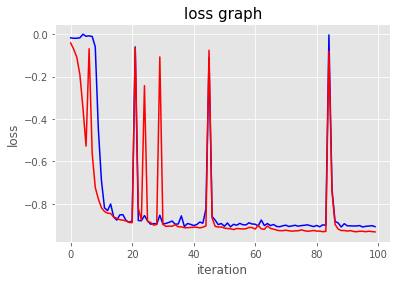

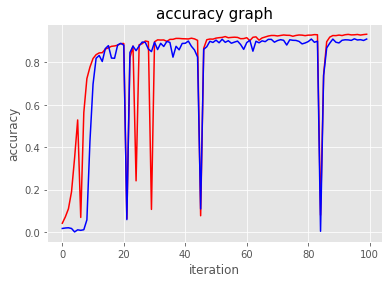

In [ ]:
traindice = history.history['dice_coef']
testdice = history.history['val_dice_coef']

trainjaccard = history.history['iou']
testjaccard = history.history['val_iou']

##loss
trainloss = history.history['loss']
testloss = history.history['val_loss']
plt.figure(1)
plt.plot(testloss, 'b-')
plt.plot(trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)

#accuracy
plt.figure(2)
plt.plot(traindice, 'r-')
plt.plot(testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

# preparing the test dataset

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [ ]:
image_test_generator = test_datagen.flow_from_dataframe(
df_test,
x_col = "filename",
class_mode = None,
color_mode = "rgb",
target_size = (256,256),
batch_size = 32,
save_prefix  = "image",
seed = 1)

mask_test_generator = test_datagen.flow_from_dataframe(
df_test,
x_col = "mask",
class_mode = None,
color_mode = "grayscale",
target_size = (256,256),
batch_size = 32,
save_prefix  = "mask",
seed = 1)

Found 393 validated image filenames.
Found 393 validated image filenames.


# testing the data on test dataset

In [ ]:
test_gen = zip(image_test_generator, mask_test_generator)
test_result = model.evaluate(test_gen , steps=len(df_test)/32)

12/12 [==============================] - 156s 14s/step - loss: -0.8994 - dice_coef: 0.9011 - iou: 0.8232


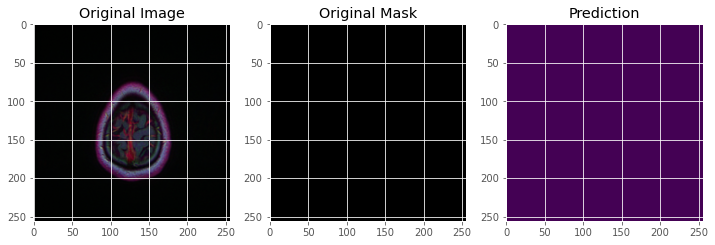

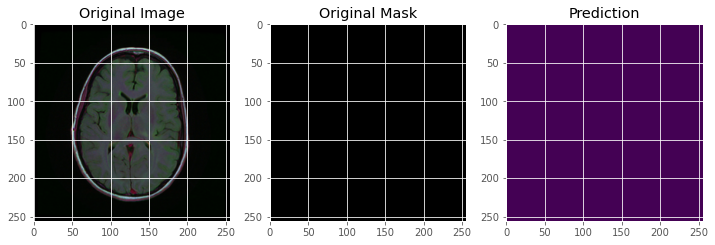

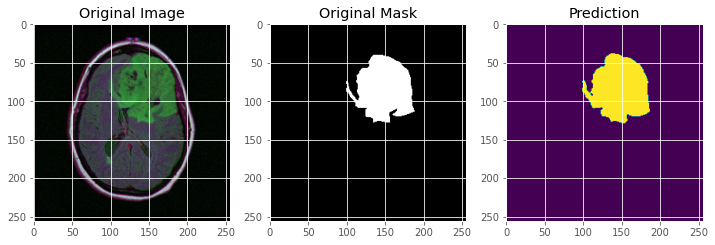

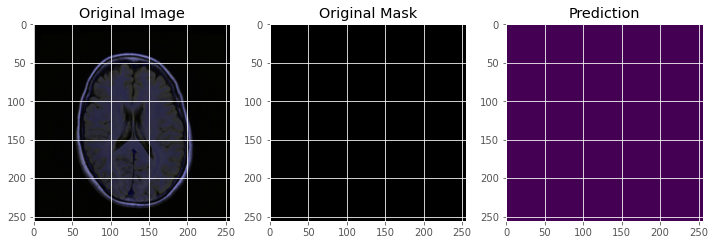

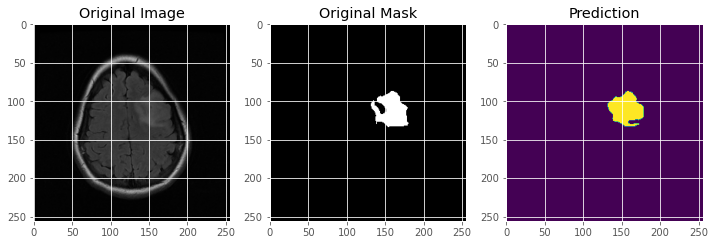

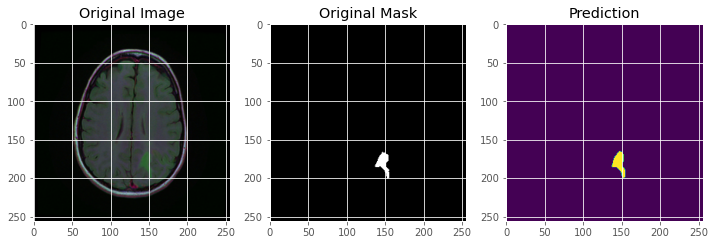

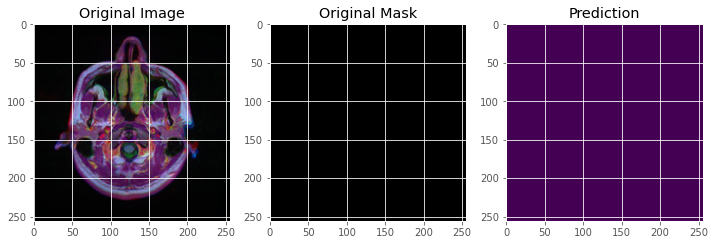

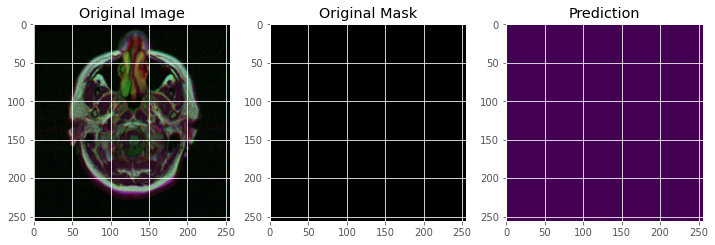

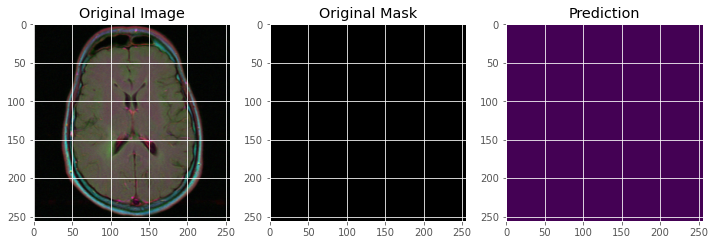

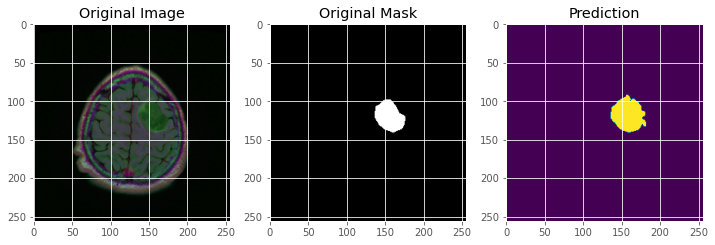

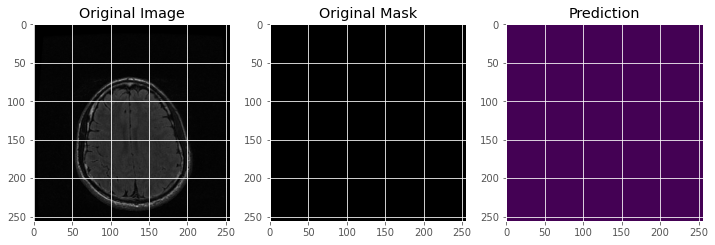

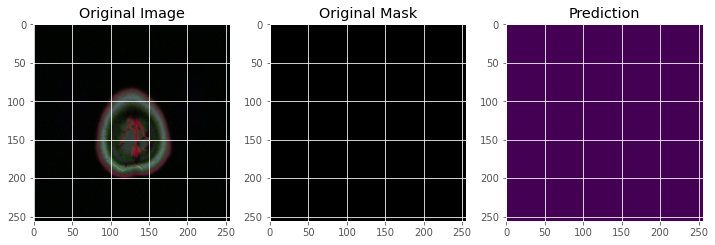

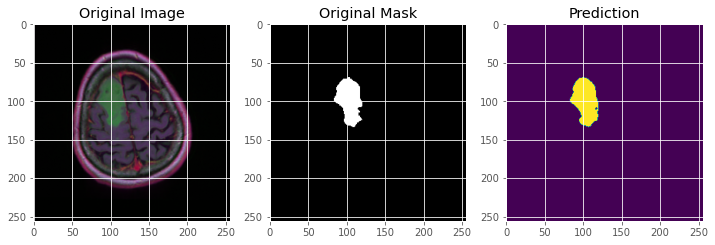

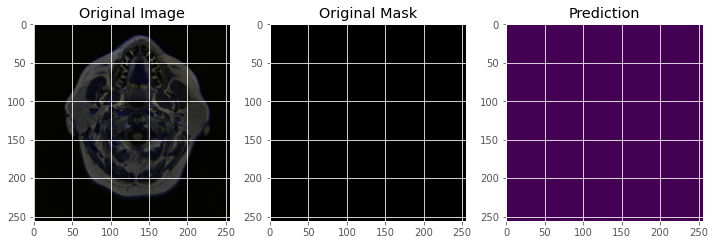

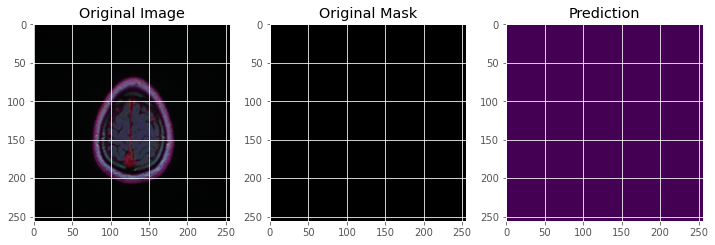

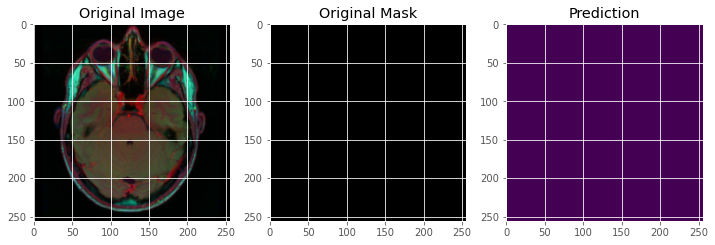

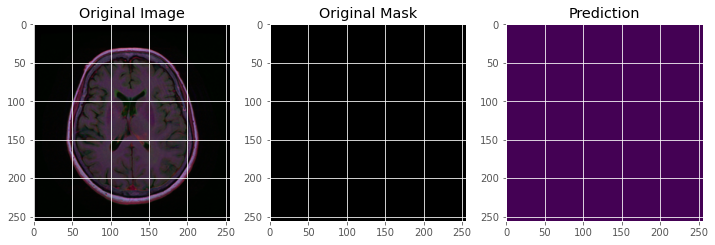

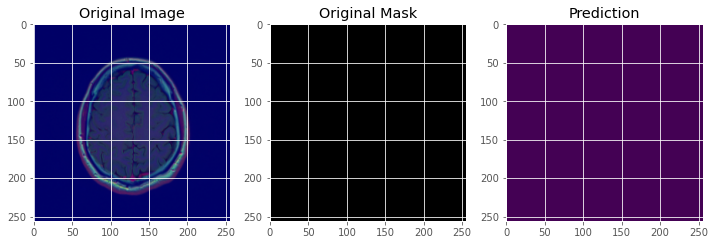

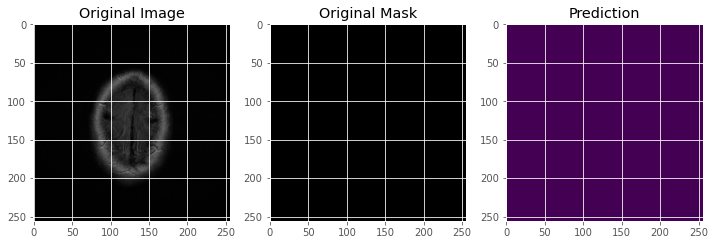

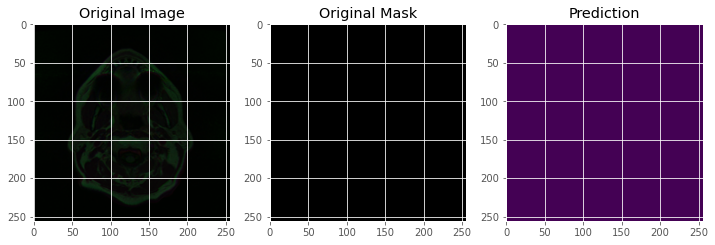

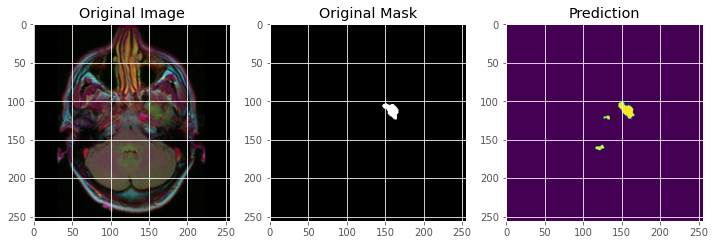

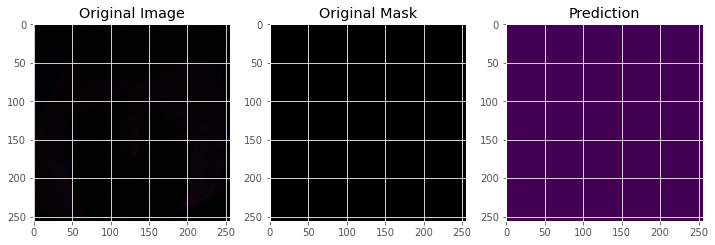

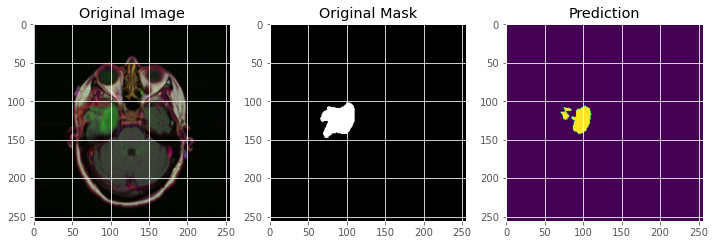

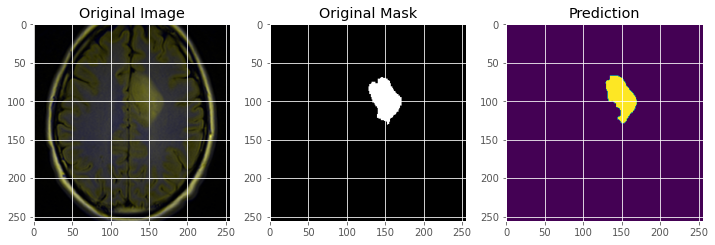

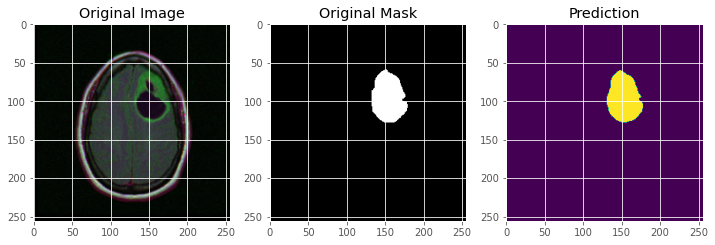

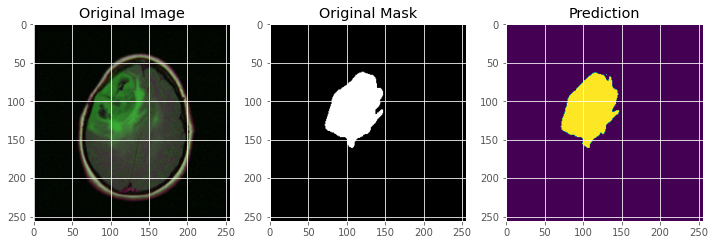

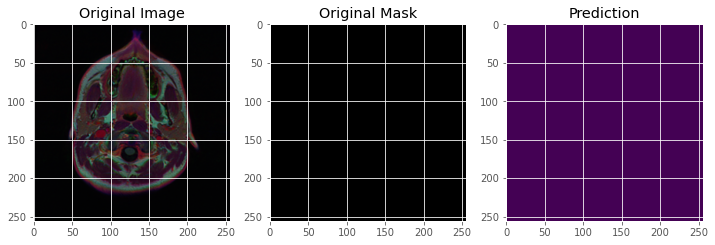

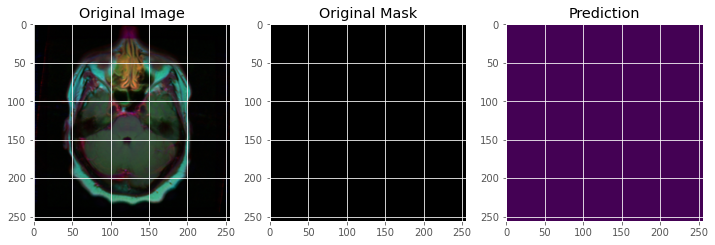

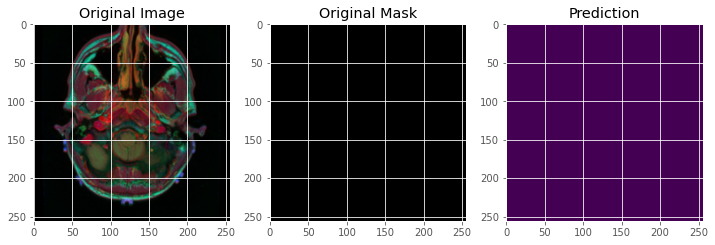

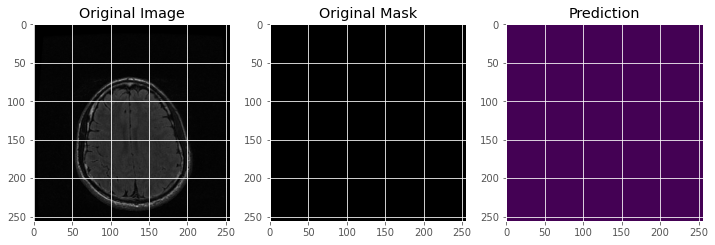

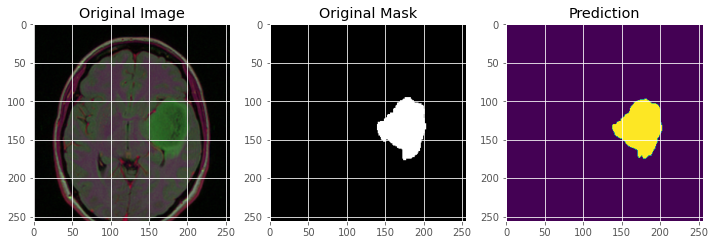

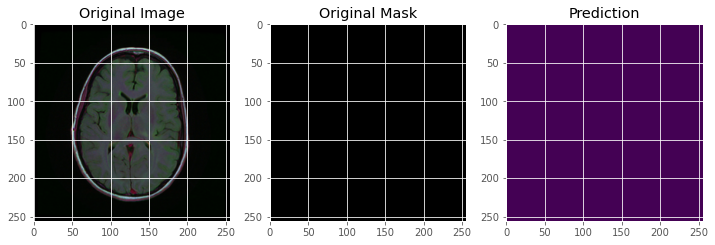

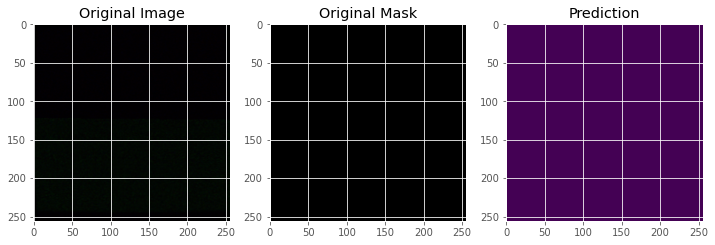

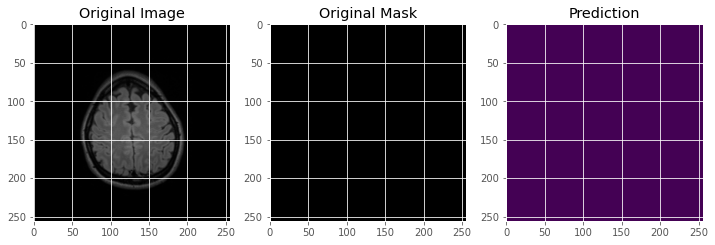

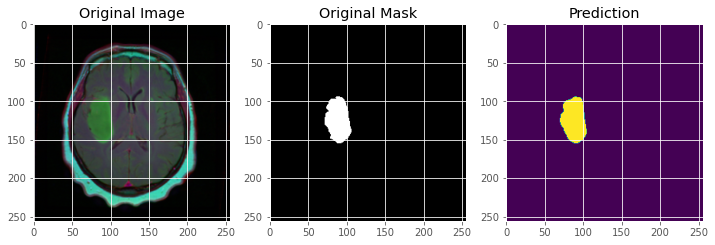

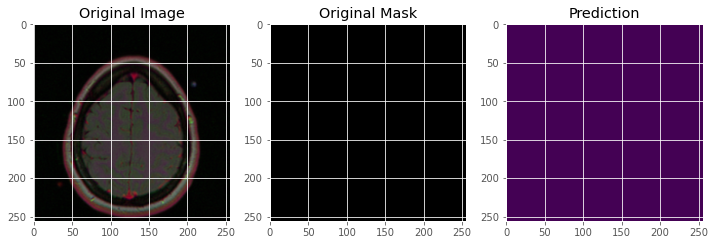

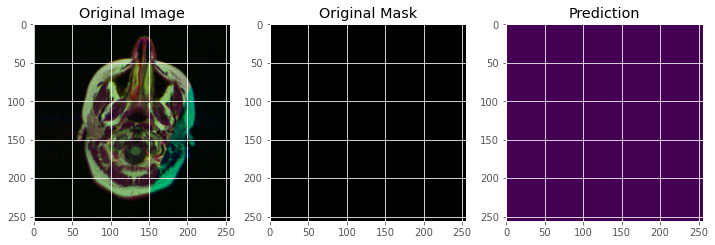

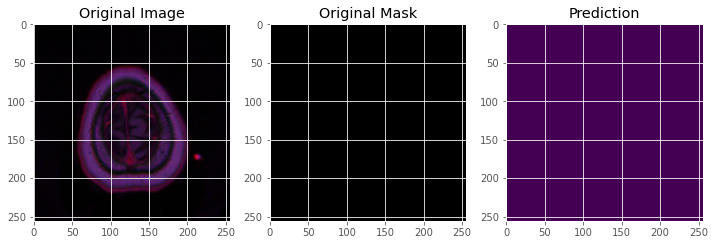

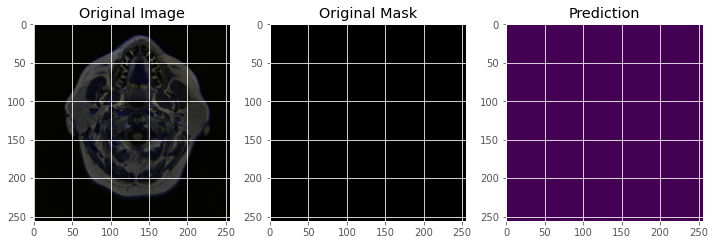

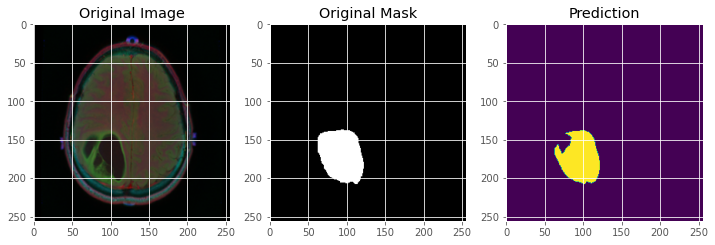

In [ ]:
for i in range(40):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()